# IEEE-CIS Fraud Detection -- Model

In [84]:
import pandas as pd
import numpy as np
import pickle
import gc
import warnings
warnings.filterwarnings('ignore')

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('classic')
sns.set_palette('deep')
sns.set_style('white')
%matplotlib inline

In [136]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [362]:
%%time
df = pd.read_csv('./Data/processed_data.csv')

CPU times: user 49.5 s, sys: 22.5 s, total: 1min 11s
Wall time: 1min 22s


In [363]:
df = df.drop('Unnamed: 0', axis=1)

In [364]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,...,Year,Month,Weekday,Day,Hour
0,2987000,0,86400,68.5,W,...,2017,12,5,2,0
1,2987001,0,86401,29.0,W,...,2017,12,5,2,0
2,2987002,0,86469,59.0,W,...,2017,12,5,2,0
3,2987003,0,86499,50.0,W,...,2017,12,5,2,0
4,2987004,0,86506,50.0,H,...,2017,12,5,2,0


## Feature Engineering

### Create feature: Card ID
- The number of digits of a credit or debit card is around 16.
- In card identify features, the combination of [*card1*, *card2*, *card3* and *card5*] gives a number around 14-16. And we may use this combination as card ID.

In [281]:
def corret_card_id(x): 
    x=x.replace('.0','')
    x=x.replace('-999','nan')
    return x

def definie_indexes(df):
    # create card ID 
    cards_cols= ['card1', 'card2', 'card3', 'card5']
    for card in cards_cols: 
        if '1' in card: 
            df['Card_ID']= df[card].map(str)
        else : 
            df['Card_ID']+= ' '+df[card].map(str)
    
    # sort train data by Card_ID and then by transaction date 
    df= df.sort_values(['Card_ID', 'Date'], ascending=[True, True])
    
    # small correction of the Card_ID
    df['Card_ID']=df['Card_ID'].apply(corret_card_id)
    
    # set indexes 
    # df= df.set_index(['Card_ID', 'Date'])
    return df

In [365]:
%%capture
definie_indexes(df)

In [366]:
df['Card_ID']=df['Card_ID'].apply(corret_card_id)

In [293]:
df[['Card_ID', 'isFraud','TransactionDT','TransactionAmt','ProductCD', 'P_emaildomain', 
    'R_emaildomain', 'DeviceType', 'DeviceInfo']].head()

,Card_ID,isFraud,TransactionDT,TransactionAmt,ProductCD,P_emaildomain,R_emaildomain,DeviceType,DeviceInfo
0,13926 nan 150 142,0,86400,68.5,W,NaN,NaN,NaN,NaN
1,2755 404 150 102,0,86401,29.0,W,gmail.com,NaN,NaN,NaN
2,4663 490 150 166,0,86469,59.0,W,outlook.com,NaN,NaN,NaN
3,18132 567 150 117,0,86499,50.0,W,yahoo.com,NaN,NaN,NaN
4,4497 514 150 102,0,86506,50.0,H,gmail.com,NaN,mobile,SAMSUNG SM-G892A Build/NRD90M


In [47]:
df['Card_ID'].value_counts()[df['Card_ID'].value_counts().values > 10000]

9500 321 150 226     26121
15885 545 185 138    22580
7919 194 150 166     21866
17188 321 150 226    19499
15066 170 150 102    14542
6019 583 150 226     13212
12695 490 150 226    12690
12544 321 150 226    12658
2803 100 150 226     10989
7585 553 150 226     10063
Name: Card_ID, dtype: int64

In [43]:
df[df['Card_ID'] == '9500 321 150 226'][['isFraud','ProductCD', 'P_emaildomain', 'R_emaildomain',
                                         'card4', 'card6', 'DeviceType', 'DeviceInfo']].apply(
    lambda x: x.nunique(), axis=0)

isFraud            3
ProductCD          5
P_emaildomain     43
R_emaildomain     25
card4              1
card6              1
DeviceType         2
DeviceInfo       115
dtype: int64

- There are 10 credit cards have transaction records more than 10000.
- For the *Card_ID* with the greatest number of transactions, *P_emaildomain* has 43 different values and the *DeviceInfo* has 115 unique values which is really weird.
- Let's see whether *Card_ID* is valid.

### Drop columns
- Drop columns with Na values more than 90%.
- Drop columns that only have one values. The columns contain no information in detecting fraud or not.

In [367]:
train = df[df['is_train'] == 1]
test = df[df['is_train'] == 0]

In [368]:
train_target = train.sort_values('TransactionDT')['isFraud']
train_features = train.sort_values('TransactionDT').drop('isFraud', axis=1)

In [369]:
test_features = test.sort_values('TransactionDT').drop('isFraud', axis=1)
test_res = test_features[["TransactionDT"]]

In [358]:
train_null_cols = [col for col in train_features.columns 
                   if train_features[col].isnull().sum() / train_features.shape[0] >= 0.9]
test_null_cols = [col for col in test_features.columns 
                  if test_features[col].isnull().sum() / test_features.shape[0] >= 0.9]

In [359]:
train_one_value_cols = [col for col in train_features.columns if train_features[col].nunique() <= 1]
test_one_value_cols = [col for col in test_features.columns if test_features[col].nunique() <= 1]

In [360]:
cols_to_drop = list(set(train_null_cols + test_null_cols + train_one_value_cols + test_one_value_cols))

In [301]:
print('Number of columns that are to drop: ', len(cols_to_drop))
print('Columns names: ', cols_to_drop)

Number of columns that are to drop:  13
Columns names:  ['dist2', 'id_24', 'id_22', 'D7', 'id_25', 'id_27', 'id_18', 'id_08', 'id_23', 'id_07', 'is_train', 'id_26', 'id_21']


In [370]:
train_features = train_features.drop(cols_to_drop, axis=1)
test_features = test_features.drop(cols_to_drop, axis=1)

In [371]:
train = train.drop(cols_to_drop, axis=1)
test = test.drop(cols_to_drop, axis=1)

In [372]:
train_features.shape

(590540, 429)

In [373]:
test_features.shape

(506691, 429)

### Encode categorical features

In [349]:
cat_cols = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
            'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9',
            'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_28', 'id_29',
            'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 
            'DeviceType', 'DeviceInfo', 'Card_ID']

In [108]:
from sklearn import preprocessing

In [374]:
for col in cat_cols:
    if col in train_features.columns:
        le = preprocessing.LabelEncoder()
        le.fit(list(train_features[col].astype(str).values) + list(test_features[col].astype(str).values))
        train_features[col] = le.transform(list(train_features[col].astype(str).values))
        test_features[col] = le.transform(list(test_features[col].astype(str).values))   

### Drop highly correlated features

In [335]:
%%time
corr_matrix = train[train['isFraud'].notnull()].corr().abs()

CPU times: user 5min 18s, sys: 13.8 s, total: 5min 32s
Wall time: 5min 46s


In [375]:
# Getting the upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

print('Number of columns to remove: ', (len(to_drop)))
print('Columns names: ', to_drop)

Number of columns to remove:  137
Columns names:  ['TransactionDT', 'C2', 'C4', 'C6', 'C8', 'C10', 'C11', 'C12', 'C14', 'D2', 'D6', 'D12', 'V11', 'V16', 'V18', 'V21', 'V22', 'V28', 'V30', 'V32', 'V33', 'V34', 'V43', 'V49', 'V50', 'V52', 'V57', 'V58', 'V60', 'V63', 'V70', 'V71', 'V72', 'V74', 'V81', 'V84', 'V89', 'V91', 'V92', 'V93', 'V94', 'V97', 'V101', 'V102', 'V103', 'V106', 'V126', 'V127', 'V128', 'V132', 'V133', 'V134', 'V143', 'V145', 'V149', 'V150', 'V151', 'V153', 'V154', 'V155', 'V156', 'V158', 'V159', 'V160', 'V163', 'V164', 'V167', 'V168', 'V177', 'V178', 'V179', 'V182', 'V192', 'V193', 'V196', 'V199', 'V202', 'V204', 'V206', 'V211', 'V212', 'V213', 'V217', 'V219', 'V222', 'V225', 'V231', 'V232', 'V233', 'V236', 'V237', 'V244', 'V249', 'V251', 'V253', 'V254', 'V256', 'V263', 'V265', 'V266', 'V269', 'V272', 'V273', 'V275', 'V276', 'V277', 'V278', 'V279', 'V280', 'V292', 'V293', 'V294', 'V295', 'V296', 'V298', 'V299', 'V304', 'V306', 'V307', 'V308', 'V311', 'V316', 'V317', 'V3

- Most correlated features are v-features.

In [376]:
train = train.drop(columns = to_drop)
test = test.drop(columns = to_drop)

In [377]:
train_features = train.drop('isFraud', axis=1)
train_target = train['isFraud']
test_features = test.drop('isFraud', axis=1)

In [378]:
train_features.shape

(590540, 292)

In [379]:
test_features.shape

(506691, 292)

In [341]:
train_features = reduce_mem_usage(train_features)

Memory usage of dataframe is 1320.10 MB
Memory usage after optimization is: 364.27 MB
Decreased by 72.4%


In [380]:
test_features = reduce_mem_usage(test_features)

Memory usage of dataframe is 1132.66 MB
Memory usage after optimization is: 320.36 MB
Decreased by 71.7%


In [347]:
del cat_cols, col, cols_to_drop, le, test, test_null_cols, test_one_value_cols, to_drop, train_null_cols, train_one_value_cols, upper; gc.collect()

28413

## Model

### Train & validation split
- Since the train and test data were collected in time series manner and there's existing a gap, split the train and validation data based using TimeSeriesSplit. 

In [218]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, auc
import lightgbm as lgb

In [175]:
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

In [212]:
params = {"boosting_type": 'gbdt',
          'num_leaves': 256,
          'min_child_samples': 79,
          'objective': 'binary',
          'max_depth': 13,
          'learning_rate': 0.03,
          "subsample_freq": 3,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'auc',
          "verbosity": 2,
          'reg_alpha': 0.3,
          'reg_lambda': 0.3,
          'colsample_bytree': 0.9,
          'categorical_feature': cat_cols,
          'random_state': 0
         }

In [350]:
score_mean = 0
for train_idx, validation_idx in tscv.split(train_features, train_target):
    lgb_model = lgb.LGBMClassifier(boosting_type='gbdt',
                                   num_leaves=256,
                                   min_child_samples=79,
                                   objective='binary',
                                   max_depth=13,
                                   learning_rate=0.03,
                                   subsample_freq=3,
                                   subsample=0.9,
                                   bagging_seed=11,
                                   metric='auc',
                                   verbosity=2,
                                   reg_alpha=0.3,
                                   reg_lambda=0.3,
                                   colsample_bytree=0.9,
                                   categorical_feature=cat_cols,
                                   random_state=0)

    X_train, X_validation = train_features.iloc[train_idx, :], train_features.iloc[validation_idx, :]
    y_train, y_validation = train_target.iloc[train_idx], train_target.iloc[validation_idx]

    lgb_model.fit(X_train, y_train)

    y_pred_train = lgb_model.predict_proba(X_validation)[:,1]
    score = roc_auc_score(y_validation, y_pred_train)
    score_mean += score
    print(f'ROC AUC {score}')

ROC AUC 0.8862082595996322
ROC AUC 0.9091301100920559
ROC AUC 0.8976562859795004
ROC AUC 0.9156490924748802
ROC AUC 0.9113978046359759


In [351]:
import matplotlib.pyplot as plt

In [352]:
feature_importance = pd.concat([pd.DataFrame(train_features.columns.values), 
                               pd.DataFrame(lgb_model.feature_importances_)], axis=1)

In [353]:
feature_importance.columns = 'Feature_name', 'score'

Text(0.5, 1.0, 'Feature Importance')

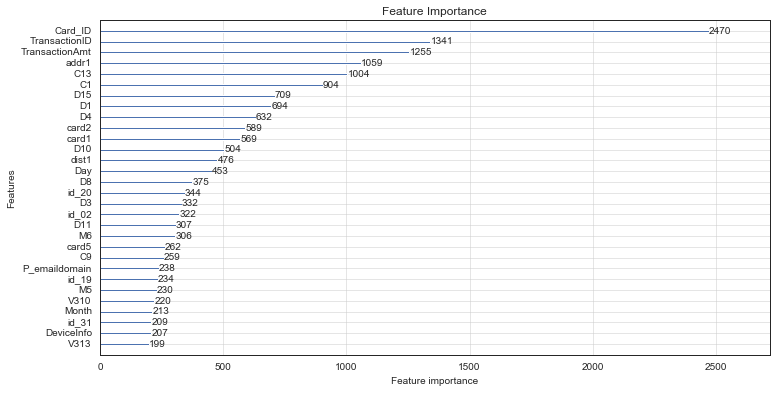

In [354]:
lgb.plot_importance(lgb_model, max_num_features=30, figsize=(12,6)).set_title("Feature Importance")

## Prediction

In [275]:
submission_sample = pd.read_csv('./Data/sample_submission.csv')

In [381]:
test_pred = lgb_model.predict_proba(test_features)[:,1]

In [387]:
submission_sample['isFraud'] = test_pred

In [393]:
submission_sample.to_csv('./Output/LGBM_model.csv', index=False)

## Reference
- https://www.kaggle.com/smerllo/identify-unique-cards-id